In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm as cm

import pandas as pd
import numpy as np

from time import time, clock
import itertools
import re

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

from sklearn.lda import LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from xgboost import XGBClassifier

%matplotlib inline

C:\Program Files\Python 3.4\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\Python 3.4\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Data loading and preprocessing

In [ ]:
path = 'C:/Users/Hoël/Documents/vrais documents/AIC/Biomed/Opioids/Data.raw/'

In [2]:
df = pd.read_csv(path+'prescriber-info.csv')
print(df.shape)
df.head()

(25000, 256)


,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [3]:
opioids = pd.read_csv(path+'opioids.csv')
print(opioids.shape)
opioids.head()

(113, 2)


,Drug Name,Generic Name
0,ABSTRAL,FENTANYL CITRATE
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
2,ACTIQ,FENTANYL CITRATE
3,ASCOMP WITH CODEINE,CODEINE/BUTALBITAL/ASA/CAFFEIN
4,ASPIRIN-CAFFEINE-DIHYDROCODEIN,DIHYDROCODEINE/ASPIRIN/CAFFEIN


In [4]:
#replace hyphens and spaces with periods to match the dataset
opioids_names = list(re.sub(r'[-\s]','.',x) for x in opioids.values[:,0])
#determe how many/ what opioids are mentioned in the data
df_cols = list(df.columns)
common_drugs = [name for name in df_cols if name in opioids_names]
print("there are %d opioids cited among the drugs"%len(common_drugs))

there are 11 opioids cited among the drugs


In [5]:
#removing opioid prescriptions from the data, otherwise we'll be cheating!
df_cols_no_opioids = [col for col in df_cols if not col in opioids_names]
df_no_opioids = df[df_cols_no_opioids].copy()

In [6]:
#factorizing categorical variables
uniques = dict()
Categorical=['Gender','State','Credentials','Specialty']
for col in Categorical:
    uniques[col] = df_no_opioids[col].unique()
    df_no_opioids[col] = pd.factorize(df_no_opioids[col])[0]

## Classifiers comparison

In [7]:
#split our dataset into train/validation/test sets
X = df_no_opioids.drop('Opioid.Prescriber',axis = 1)
y = df_no_opioids['Opioid.Prescriber']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)
nsplits = 5
kfold = KFold(n_splits = nsplits)

In [14]:
model = RandomForestClassifier(n_estimators=150, criterion ='entropy')
model.fit(X_train,y_train)

y_probas = [proba[1] for proba in model.predict_proba(X_test)]
y_pred = model.predict(X_test)

print("AUC: %.4f" %roc_auc_score(y_test,y_probas))
print("Mean accuracy : %.4f" %np.mean(y_pred == y_test))

AUC: 0.9170
Mean accuracy : 0.8366


In [27]:
model = RandomForestClassifier(n_estimators=150, criterion ='gini')
model.fit(X_train,y_train)

y_probas = [proba[1] for proba in model.predict_proba(X_test)]
y_pred = model.predict(X_test)

print("AUC: %.4f" %roc_auc_score(y_test,y_probas))
print("Mean accuracy : %.4f" %np.mean(y_pred == y_test))

AUC: 0.9161
Mean accuracy : 0.8402


In [15]:
model = XGBClassifier()
model.fit(X_train,y_train)

y_probas = [proba[1] for proba in model.predict_proba(X_test)]
y_pred = model.predict(X_test)

print("AUC: %.4f" %roc_auc_score(y_test,y_probas))
print("Mean accuracy : %.4f" %np.mean(y_pred == y_test))

AUC: 0.9015
Mean accuracy : 0.8230


In [16]:
model = AdaBoostClassifier(n_estimators=600, learning_rate=0.5, random_state=88)
model.fit(X_train,y_train)

y_probas = [proba[1] for proba in model.predict_proba(X_test)]
y_pred = model.predict(X_test)

print("AUC: %.4f" %roc_auc_score(y_test,y_probas))
print("Mean accuracy : %.4f" %np.mean(y_pred == y_test))

AUC: 0.8987
Mean accuracy : 0.8186


In [22]:
model = MLPClassifier(random_state=55)
model.fit(X_train,y_train)

y_probas = [proba[1] for proba in model.predict_proba(X_test)]
y_pred = model.predict(X_test)

print("AUC: %.4f" %roc_auc_score(y_test,y_probas))
print("Mean accuracy : %.4f" %np.mean(y_pred == y_test))

AUC: 0.5000
Mean accuracy : 0.5850


In [24]:
model = LDA()
model.fit(X_train,y_train)

y_probas = [proba[1] for proba in model.predict_proba(X_test)]
y_pred = model.predict(X_test)

print("AUC: %.4f" %roc_auc_score(y_test,y_probas))
print("Mean accuracy : %.4f" %np.mean(y_pred == y_test))

AUC: 0.8092
Mean accuracy : 0.7100


In [9]:
model = GaussianNB()
model.fit(X_train,y_train)

y_probas = [proba[1] for proba in model.predict_proba(X_test)]
y_pred = model.predict(X_test)

print("AUC: %.4f" %roc_auc_score(y_test,y_probas))
print("Mean accuracy : %.4f" %np.mean(y_pred == y_test))

AUC: 0.5135
Mean accuracy : 0.5850


In [8]:
model = SGDClassifier(loss = 'log')
model.fit(X_train,y_train)

y_probas = [proba[1] for proba in model.predict_proba(X_test)]
y_pred = model.predict(X_test)

print("AUC: %.4f" %roc_auc_score(y_test,y_probas))
print("Mean accuracy : %.4f" %np.mean(y_pred == y_test))

AUC: 0.5000
Mean accuracy : 0.5850


In [ ]:
model = RandomForestClassifier(n_estimators=150, criterion ='entropy')
selector = RFE(estimator=model)
selector = selector.fit(X_train, y_train)

y_probas = [proba[1] for proba in selector.predict_proba(X_test)]
y_pred = selector.predict(X_test)
print("AUC: %.4f" %roc_auc_score(y_test,y_probas))
print("Mean accuracy : %.4f" %np.mean(y_pred == y_test))

# Dimensionality reduction

For 1 components
mean AUC: 0.5086
For 2 components
mean AUC: 0.5086
For 3 components
mean AUC: 0.5086
For 4 components
mean AUC: 0.5086
For 5 components
mean AUC: 0.5086
For 6 components
mean AUC: 0.5086
For 7 components
mean AUC: 0.5086
For 8 components
mean AUC: 0.5086
For 9 components
mean AUC: 0.5086
For 10 components
mean AUC: 0.5086
For 11 components
mean AUC: 0.5086
For 12 components
mean AUC: 0.5086
For 13 components
mean AUC: 0.5086
For 14 components
mean AUC: 0.5086
For 15 components
mean AUC: 0.5086
For 16 components
mean AUC: 0.5086
For 17 components
mean AUC: 0.5086
For 18 components
mean AUC: 0.5086
For 19 components
mean AUC: 0.5086
Computation time: 1551.33s


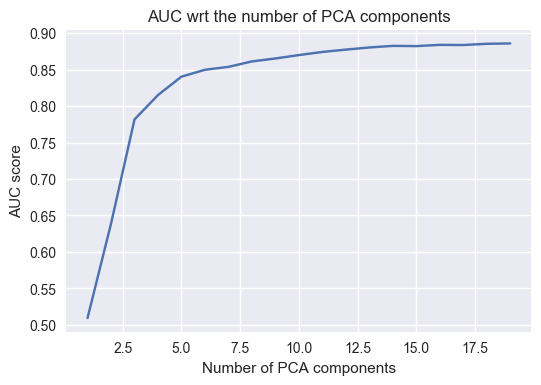

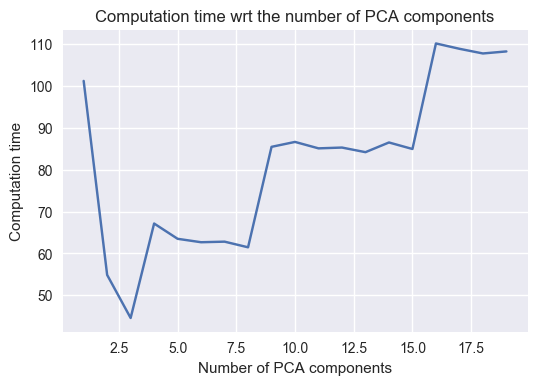

In [89]:
# Optimisation du nombre de composantes dans la PCA
tps = clock()
scores = []
times = []
model = RandomForestClassifier(n_estimators=150, criterion ='entropy')
max_comp = 20
for n_comp in range(1,max_comp):
    tps2 = clock()
    pca = PCA(n_components=n_comp)
    score = 0
    for train_index,test_index in kfold.split(X):
        Xtr,Ytr = X.loc[train_index],y.loc[train_index]
        Xte,Yte = X.loc[test_index],y.loc[test_index]
    
        Xtr_new = pca.fit_transform(Xtr,Ytr)
        model.fit(Xtr_new,Ytr)
    
        Xte_new = pca.transform(Xte)
        y_probas = [proba[1] for proba in model.predict_proba(Xte_new)]
        score += roc_auc_score(Yte,y_probas)
    
    score /= nsplits
    scores.append(score)
    times.append(clock()-tps2)
    print("For %i components"%n_comp)
    print("mean AUC: %.4f"%score)

print("Computation time: %.2fs" %(clock()-tps))
plt.plot(np.arange(1,max_comp),scores)
plt.title("AUC wrt the number of PCA components")
plt.xlabel("Number of PCA components")
plt.ylabel("AUC score")
plt.figure()
plt.plot(np.arange(1,max_comp),times)
plt.title("Computation time wrt the number of PCA components")
plt.xlabel("Number of PCA components")
plt.ylabel("Computation time")

In [ ]:
# Optimization of the number of kept features in RFE method
tps = clock()
scores = []
times = []
model = RandomForestClassifier(n_estimators=150, criterion ='entropy')
max_comp = 20
for n_features in range(1,max_comp):
    tps2 = clock()
    feature_selector = RFE(model, n_features_to_select = n_features)
    score = 0
    for train_index,test_index in kfold.split(X):
        Xtr,Ytr = X.loc[train_index],y.loc[train_index]
        Xte,Yte = X.loc[test_index],y.loc[test_index]
    
        Xtr_new = feature_selector.fit_transform(Xtr,Ytr)
        model.fit(Xtr_new,Ytr)
    
        Xte_new = feature_selector.transform(Xte)
        y_probas = [proba[1] for proba in model.predict_proba(Xte_new)]
        score += roc_auc_score(Yte,y_probas)
    
    score /= nsplits
    scores.append(score)
    times.append(clock()-tps2)
    print("For %i components"%n_comp)
    print("mean AUC: %.4f"%accuracy)

print("Computation time: %.2fs" %(clock()-tps))
plt.plot(np.arange(1,max_comp),scores)
plt.title("AUC wrt the number of PCA components")
plt.xlabel("Number of PCA components")
plt.ylabel("AUC score")
plt.figure()
plt.plot(np.arange(1,max_comp),times)
plt.title("Computation time wrt the number of PCA components")
plt.xlabel("Number of PCA components")
plt.ylabel("Computation time")

# Manual threshold

Meilleure précision obtenue: 0.8382
Seuil correspondant: 0.52


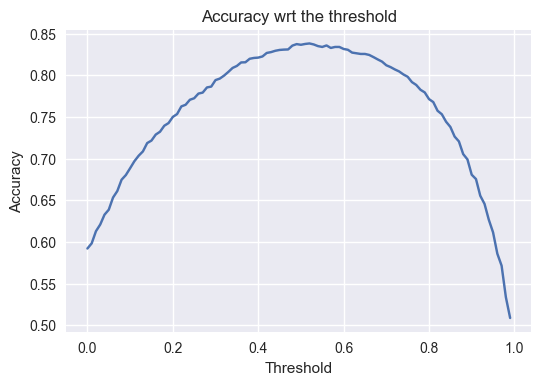

In [88]:
# Optimisation du threshold dans la RF
model = RandomForestClassifier(n_estimators=150, criterion ='entropy')
accuracies = []
max_acc = 0

Xtr, Xte, Ytr, Yte = train_test_split(X,y, test_size = 0.2, random_state=42)
model.fit(Xtr,Ytr)
y_probas = model.predict_proba(Xte)
y_probas = [proba[1] for proba in model.predict_proba(Xte)]

for threshold in np.arange(0.,1.,0.01):
    y_pred = y_probas>threshold
    accuracy = np.sum(y_pred == Yte)/len(Yte)
    accuracies.append(accuracy)
    if accuracy > max_acc:
        max_acc = accuracy
        best_thresh = threshold

print("Best accuracy: %.4f" %max_acc)
print("Corresponding threshold: %.2f" %best_thresh)
plt.plot(np.arange(0,1,0.01),accuracies)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy wrt the threshold")

# Overfitting

Temps d'exécution: 358.28s


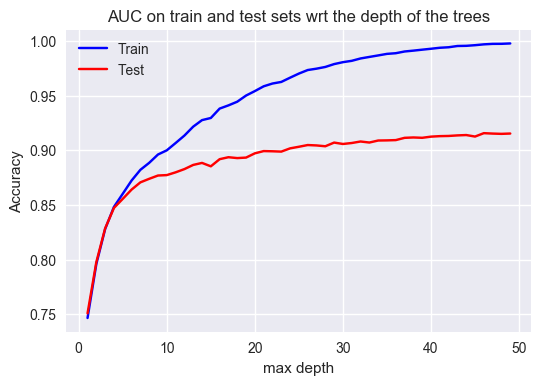

In [85]:
# Check overfitting avec le max_depth
tps = clock()
accuracies = []
max_depth = 50

Xtr, Xte, Ytr, Yte = train_test_split(X,y, test_size = 0.2, random_state=42)
tr_scores = []
te_scores = []

for depth in range(1,max_depth):
    model = RandomForestClassifier(n_estimators=150, criterion ='entropy', max_depth = depth)
    model.fit(Xtr,Ytr)
    
    train_probas = [proba[1] for proba in model.predict_proba(Xtr)]
    test_probas = [proba[1] for proba in model.predict_proba(Xte)]
    tr_score = roc_auc_score(Ytr,train_probas)
    te_score = roc_auc_score(Yte,test_probas)
    tr_scores.append(tr_score)
    te_scores.append(te_score)

print("Computation time: %.2fs" %(clock()-tps))
plt.plot(np.arange(1,max_depth),tr_scores,c = 'b',label = "Train")
plt.plot(np.arange(1,max_depth),te_scores,c = 'r',label = "Test")
plt.legend()
plt.title("AUC on train and test sets wrt the depth of the trees")
plt.xlabel("max depth")
plt.ylabel("Accuracy")